In [22]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import math
    import pandas as pd
    import numpy as np
    from datetime import datetime
    from scipy.stats import norm
    import xgboost as xgb
    from sklearn.preprocessing import StandardScaler
    from sklearn.cross_validation import cross_val_score, cross_val_predict
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.svm import SVR, SVC
    import matplotlib.pyplot as plt
    import scipy.interpolate
    from itertools import product, chain
    from sklearn.metrics import make_scorer, mean_squared_error

    from bayes_opt import BayesianOptimization


In [23]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        tmin, tsec = divmod((datetime.now() - start_time).total_seconds(), 60)
        print(" Time taken: %i minutes and %s seconds." % (tmin, round(tsec,2)))

def XGbcv( max_depth, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree):

    global RMSEbest
    global ITERbest

    paramt = {
              'booster' : 'gbtree',
              'max_depth' : max_depth.astype(int),
              'gamma' : gamma,
              'eta' : 0.01,
              'objective': 'reg:linear',
              'nthread' : 8,
              'silent' : True,
              'eval_metric': 'rmse',
              'subsample' : subsample,
              'colsample_bytree' : colsample_bytree,
              'min_child_weight' : min_child_weight,
              'max_delta_step' : max_delta_step.astype(int),
              'seed' : 1001
              }

    folds = 5

    xgbr = xgb.cv(
           paramt,
           dtrain,
           num_boost_round = 100000,
#           stratified = True,
           nfold = folds,
           verbose_eval = False,
           early_stopping_rounds = 50,
           metrics = "rmse",
           show_stdv = True
          )

    cv_score = xgbr['test-rmse-mean'].iloc[-1]
    if ( cv_score < RMSEbest ):
        RMSEbest = cv_score
        ITERbest = len(xgbr)

    return (-1.0 * cv_score)

if __name__ == "__main__":

    folds = 5
    RMSEbest = 10.
    ITERbest = 0


In [24]:
ids = test['Id']

In [25]:
#Import Data
df_train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\train.csv")
df_test = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\House_Prices\test.csv")
print ('data loaded')
print (str(len(train))+" rows for training set")
print (str(len(test))+" rows for test set")

data loaded
1456 rows for training set
1459 rows for test set


### Check for duplicates

In [26]:
idsUnique = len(set(df_train.Id))
idsTotal = df_train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
# df_train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


### Looking for outliers

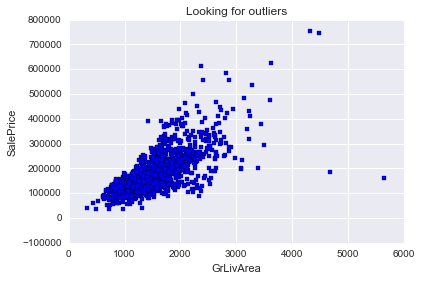

In [27]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.

### Define Median Absolute Deviation Function

In [28]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

### Remove Skew from SalesPrice data as required by the competition
Select the last column as target

In [29]:
target = df_train[df_train.columns.values[-1]]
target_log = np.log(target)

### Merge Train and Test to evaluate ranges and missing values excluding the last column
This was done primarily to ensure that Categorical data in the training and testing data sets were consistent.

In [30]:
df_train = df_train[df_train.columns.values[:-1]]
df = df_train.append(df_test, ignore_index = True)

### Find all categorical data

In [31]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)

### Create separte datasets for Continuous vs Categorical

In [32]:
df_cont = df.drop(cats, axis=1)
df_cat = df[cats]

### Handle Missing Data for continuous data
1. If any column contains more than 50 entries of missing data, drop the column
2. If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column (the median imputation used on missing values is very crude. For example, Area features with missing values may be this way because the property does not have that feature (e.g. a pool) so it would make more sense to set this to zero. )
3. Remove outliers using Median Absolute Deviation
4. Calculate skewness for each variable and if greater than 0.75 transform it
5. Apply the sklearn.Normalizer to each column

In [33]:
from sklearn.preprocessing import Normalizer
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        #print("Removing Column: {}".format(col))
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        #print("Replacing with Median: {}".format(col))
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median
        
        
        outliers = np.where(is_outlier(df_cont[col]))
        df_cont[col].iloc[outliers] = median
        
               
        if skew(df_cont[col]) > 0.75:
            #print("Skewness Detected: {}".format(col))
            df_cont[col] = np.log(df_cont[col])
            df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)
        
        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]
        

### Handle Missing Data for Categorical Data
1. If any column contains more than 50 entries of missing data, drop the column
2. If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
3. Apply the sklearn.LabelEncoder
4. For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [34]:
from sklearn.preprocessing import LabelEncoder
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

### Merge Numeric and Categorical Datasets and Create Training and Testing Data

In [36]:
df_new = df_cont.join(df_cat)

df_train = df_new.iloc[:len(df_train) - 1]
df_train = df_train.join(target_log)

df_test = df_new.iloc[len(df_train) + 1:]

X_train = df_train[df_train.columns.values[1:-1]]
y = df_train[df_train.columns.values[-1]]

X_test = df_test[df_test.columns.values[1:]]


#### Print the length for checking

In [37]:
print (str(len(y_train))+" rows for training set")
print (str(len(X_train))+" rows for test set")

1459 rows for training set
1458 rows for test set



 Train Set Matrix Dimensions: 1458 x 205

 Test Set Matrix Dimensions: 1460 x 205

# Global Optimization Search for XGboost Parameters

 Please note that negative RMSE values will be shown below. This is because
 RMSE needs to be minimized, while Bayes Optimizer always maximizes the function.

Initialization
----------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_delta_step |   max_depth |   min_child_weight |   subsample | 
    1 | 00m56s |   -0.13802 |             0.2681 |    0.3620 |           1.0397 |      5.9410 |             1.1258 |      0.8400 | 
    2 | 00m42s |   -0.13721 |             0.1940 |    0.3636 |           1.4011 |      4.4752 |             0.1427 |      0.6598 | 
    3 | 00m48s |   -0.12700 |             0.1492 |    0.0928 |           0.8459 |      3.0763 |             3.3553 |      0.6909 | 
    4 | 00m47s |   -0.13207 | 

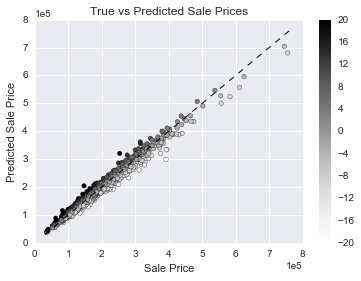


 First 10 Lines of Your Prediction:

          SalePrice
Id                 
1461.000 146298.703
1462.000 128942.414
1463.000 160214.781
1464.000 186885.547
1465.000 197908.516
1466.000 195805.484
1467.000 176719.562
1468.000 175540.562
1469.000 163271.641
1470.000 175943.312

 Writing Submission File: submission_XGb_0.123536_2016-10-16-15-23.csv
 Time taken: 0 minutes and 14.26 seconds.


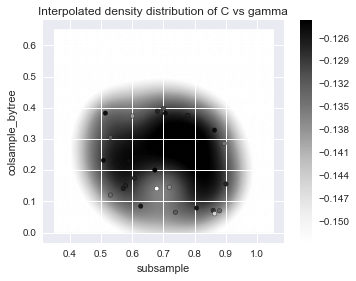


 Optimization Plot Saved:  HousePrices-XGb-5fold-01-v2.png

 Grid Search Results Saved:  HousePrices-XGb-5fold-01-v2-grid.csv



In [39]:
    dtrain = xgb.DMatrix(X_train, label=y)
    dtest = xgb.DMatrix(X_test)

    print("\n Train Set Matrix Dimensions: %d x %d" % (X_train.shape[0], X_train.shape[1]))
    print("\n Test Set Matrix Dimensions: %d x %d\n" % (X_test.shape[0], X_test.shape[1]))

    start_time = timer(None)
    print("# Global Optimization Search for XGboost Parameters")
    print("\n Please note that negative RMSE values will be shown below. This is because")
    print(" RMSE needs to be minimized, while Bayes Optimizer always maximizes the function.\n")

    XGbBO = BayesianOptimization(XGbcv, {'max_depth': (3, 10),
                                     'gamma': (0.00001, 1.0),
                                     'min_child_weight': (0, 5),
                                     'max_delta_step': (0, 5),
                                     'subsample': (0.5, 0.9),
                                     'colsample_bytree' :(0.05, 0.4)
                                    })

    XGbBO.maximize(init_points=10, n_iter=25, acq="ei", xi=0.01)
    print("-" * 53)
    timer(start_time)

    best_RMSE = round((-1.0 * XGbBO.res['max']['max_val']), 6)
    max_depth = XGbBO.res['max']['max_params']['max_depth']
    gamma = XGbBO.res['max']['max_params']['gamma']
    min_child_weight = XGbBO.res['max']['max_params']['min_child_weight']
    max_delta_step = XGbBO.res['max']['max_params']['max_delta_step']
    subsample = XGbBO.res['max']['max_params']['subsample']
    colsample_bytree = XGbBO.res['max']['max_params']['colsample_bytree']

    print("\n Best RMSE value: %f" % best_RMSE)
    print(" Best XGboost parameters:")
    print(" max_depth=%d gamma=%f min_child_weight=%f max_delta_step=%d subsample=%f colsample_bytree=%f" % (int(max_depth), gamma, min_child_weight, int(max_delta_step), subsample, colsample_bytree))

    start_time = timer(None)
    print("\n# Making Prediction")

    paramt = {
              'booster' : 'gbtree',
              'max_depth' : max_depth.astype(int),
              'gamma' : gamma,
              'eta' : 0.01,
              'objective': 'reg:linear',
              'nthread' : 8,
              'silent' : True,
              'eval_metric': 'rmse',
              'subsample' : subsample,
              'colsample_bytree' : colsample_bytree,
              'min_child_weight' : min_child_weight,
              'max_delta_step' : max_delta_step.astype(int),
              'seed' : 1001
              }

    xgbr = xgb.train(paramt, dtrain, num_boost_round=int(ITERbest*(1+(1/folds))))

    x_true = np.expm1(y)
    x_pred = np.expm1(xgbr.predict(dtrain))
# Normalized prediction error clipped to -20% to 20% range
    x_diff = np.clip(100 * ( (x_pred - x_true) / x_true ), -20, 20)
    plt.figure(1)
    plt.title("True vs Predicted Sale Prices")
    plt.scatter(x_true, x_pred, c=x_diff)
    plt.colorbar()
    plt.plot([x_true.min()-5000, x_true.max()+5000], [x_true.min()-5000, x_true.max()+5000], 'k--', lw=1)
    plt.xlabel('Sale Price')
    plt.ylabel('Predicted Sale Price')
    plt.xlim( 0, 800000 )
    plt.ylim( 0, 800000 )
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    plt.savefig('./HousePrices-XGb-' + str(folds) + 'fold-train-predictions-01-v2.png')
    plt.show(block=False)

    y_pred = np.expm1(xgbr.predict(dtest))
    result = pd.DataFrame(y_pred, columns=['SalePrice'])
    result["Id"] = ids
    result = result.set_index("Id")
    print("\n First 10 Lines of Your Prediction:\n")
    print(result.head(10))
    now = datetime.now()
    sub_file = 'submission_XGb_' + str(best_RMSE) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("\n Writing Submission File: %s" % sub_file)
    result.to_csv(sub_file, index=True, index_label='Id')
    timer(start_time)

    history_df = pd.DataFrame(XGbBO.res['all']['params'])
    history_df2 = pd.DataFrame(XGbBO.res['all']['values'])
    history_df = pd.concat((history_df, history_df2), axis=1)
    history_df.rename(columns = { 0 : 'RMSE'}, inplace=True)
    history_df.index.names = ['Iteration']

    x, y, z = history_df['subsample'].values, history_df['colsample_bytree'].values, history_df['RMSE'].values
    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(0.35, 1.05, 100), np.linspace(0, 0.65, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function='multiquadric', smooth=0.5)
    zi = rbf(xi, yi)

    plt.figure(2)
    plt.title("Interpolated density distribution of C vs gamma")
    plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[0.35, 1.05, 0, 0.65], interpolation = 'lanczos')
    plt.scatter(x, y, c=z)
    plt.colorbar()
    plt.xlabel('subsample')
    plt.ylabel('colsample_bytree')
    plt.savefig('./HousePrices-XGb-' + str(folds) + 'fold-01-v2.png')
    plt.show(block=False)
    print("\n Optimization Plot Saved:  HousePrices-XGb-%dfold-01-v2.png" % folds)

    history_df['RMSE'] = -1.0 * history_df['RMSE']
    history_df.to_csv("./HousePrices-XGb-" + str(folds) + "fold-01-v2-grid.csv")
    print("\n Grid Search Results Saved:  HousePrices-XGb-%dfold-01-v2-grid.csv\n" % folds)